# Data Explanation & Cleaning & Selection

In this section, we will first understand the Yelp Open Dataset and select the desired data for recommendation


The Yelp Open Dataset is available for download here: https://www.yelp.com/dataset

We save the cleaned data as pickle file and so that backend server can consume.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Busniess table

In [5]:
# Read business.json file as DataFrame and show the basic info
business = pd.read_json('./Dataset/yelp_academic_dataset_business.json',lines=True)
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


1. After checked the table, we noticed there are some values entirely in upper/lower case, and also some values that are invalid. 
2. So we will attempt to reduce the errors by converting all values to lower case and count the number of unique values.
3. Standardize all city names to lowercase and remove duplicates⬇️

In [6]:
city_names = business['city'].str.lower().value_counts()

Visualize the data ⬇️

In [7]:
def plotTopFreq(dat, var, top_n, title):
    Categories={}
    for cat in dat[var].values:
        if cat != None:
            all_categories = cat.split(",")
            all_categories = [x.strip() for x in all_categories]
        for x in all_categories:
            try :
                Categories[x] = Categories[x] + 1
            except:
                Categories[x]=1
    top_categories = pd.DataFrame.from_dict(data = Categories,orient="index")
    top_categories.reset_index(inplace=True)
    top_categories.columns = ['category', 'occurance']

    x_val = top_categories.sort_values("occurance")[::-1][:top_n].occurance.values
    labels = top_categories.sort_values("occurance")[::-1][:top_n].category.values
    series = pd.Series(x_val, index = labels, name = title)
    series.plot.pie(figsize = (10, 10),startangle = 90)

 Show top 15 business categories⬇️

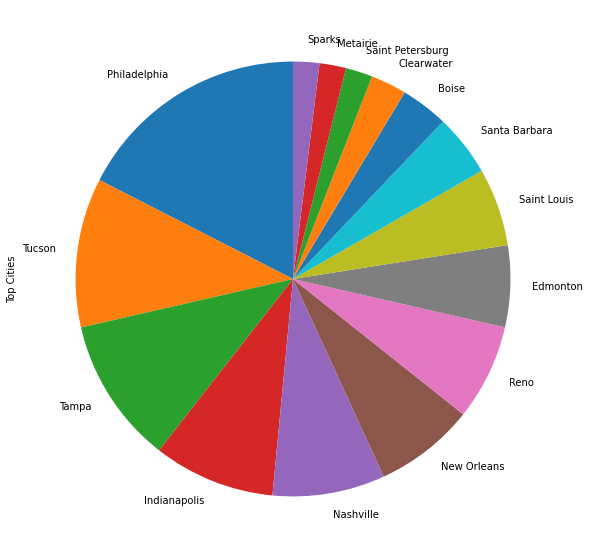

In [8]:
business_df = business.rename(columns = {'name': 'business_name'})
plotTopFreq(business_df,"city",15,"Top Cities")

Philadelphia takes the most percentage. To minimize the dataset for fast response, we only use the business located in philadelphia

In [9]:
top1_city = ['philadelphia']

Confirm city filter is working as intended and count the total number of selected records

In [10]:
print('Total value count for philadelphia:', city_names[top1_city].sum())
city_names[top1_city]
len(business)

Total value count for philadelphia: 14576


philadelphia    14576
Name: city, dtype: int64

150346

Filter the business table itself using the list of philadelphia and confirm sum is same as total value count above

In [11]:
business[business['city'].str.lower().isin(top1_city)]['city'].value_counts().sum()

14576

Filter and update the business table(only "philadelphia")

In [12]:
business = business[business['city'].str.lower().isin(top1_city)]
len(business)

14576

### Filter down businesses containing "restaurant"

1. We will next look at the category column and further filter our records by the selected category(restaurant).
2. We notice that the categories of business is a string and to further analyze the individual category values we will use split to separate them. And use the `MultiLabelBinarizer` function to break apart each of these individual category values into its own column.

In [13]:
business['categories'].value_counts()

Restaurants, Pizza                                                                                                          154
Pizza, Restaurants                                                                                                          124
Restaurants, Chinese                                                                                                         89
Nail Salons, Beauty & Spas                                                                                                   86
Chinese, Restaurants                                                                                                         84
                                                                                                                           ... 
Food, Sandwiches, Fast Food, Restaurants, Diners, Seafood, Street Vendors                                                     1
Restaurants, Italian, Chicken Wings, Pizza                                                              

In [14]:
cs = set(business['categories'])

We can see that most of the restaurants have "restaurant" or "food" in their categories.

In [15]:
csr = set()
for cat in cs:
    if cat and ("Restaurant" in cat or "Food" in cat):
        csr.add(cat)
len(csr)

5067

In [16]:
business = business[business['categories'].isin(csr)]
len(business)

7082

In [17]:
business['categories'].iloc[0]
type(business['categories'].iloc[0])

business['categories'].str.split(', ').iloc[0]
type(business['categories'].str.split(', ').iloc[0])

'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries'

str

['Restaurants', 'Food', 'Bubble Tea', 'Coffee & Tea', 'Bakeries']

list

Convert categories column from a string type to a list of values

In [18]:
category_lists = business['categories'].str.split(', ')
print(category_lists)

3         [Restaurants, Food, Bubble Tea, Coffee & Tea, ...
15                      [Sushi Bars, Restaurants, Japanese]
19                                    [Korean, Restaurants]
28        [Cocktail Bars, Bars, Italian, Nightlife, Rest...
31                        [Pizza, Restaurants, Salad, Soup]
                                ...                        
150287                           [Restaurants, Food Stands]
150298                   [Sandwiches, Restaurants, Italian]
150306    [Restaurants, Specialty Food, Food, Sandwiches...
150319    [Coffee & Tea, Food, Sandwiches, American (Tra...
150336                               [Restaurants, Mexican]
Name: categories, Length: 7082, dtype: object


Drop null values⬇️

In [19]:
category_lists = category_lists.dropna()

Transform the series into an array

In [20]:
mlb = MultiLabelBinarizer()
category_mlb = mlb.fit_transform(category_lists)

Transform the array into a dataframe

In [21]:
category_matrix = pd.DataFrame(category_mlb, columns = mlb.classes_, index = category_lists.index)
category_matrix.shape

(7082, 468)

In [22]:
category_matrix.sum().sort_values(ascending = False).head(10)

Restaurants               5854
Food                      3109
Nightlife                 1080
Bars                      1018
Sandwiches                 929
Coffee & Tea               894
Pizza                      800
American (New)             751
Breakfast & Brunch         687
American (Traditional)     663
dtype: int64

make sure that the restaurant category is reliable enough

In [23]:
# Save the list of unique category values and their value counts
list_of_categories = category_matrix.sum().sort_values(ascending = True)

Plot a horizontal bar chart of the top 20 category values⬇️

<Figure size 432x432 with 0 Axes>

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Top 20 Business Category Types Within philadelphia')

Text(0, 0.5, 'Business Category Names')

Text(0.5, 0, 'Value Counts')

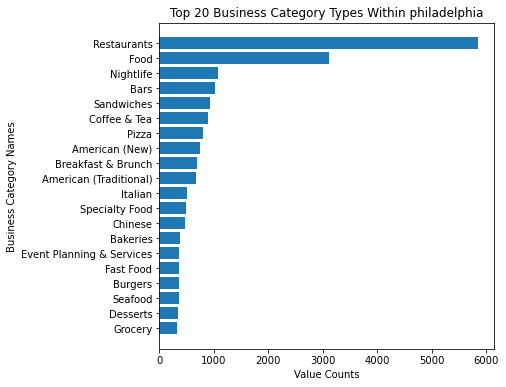

In [24]:
plt.figure(figsize = (6,6))
plt.barh(list_of_categories.tail(20).index, list_of_categories.tail(20).values)
plt.title('Top 20 Business Category Types Within philadelphia')
plt.ylabel('Business Category Names')
plt.xlabel('Value Counts')
plt.show()

To compare the relationship beween "food" and "restaurat", we review all value counts for each category column that coincides with the Food category but not with the Restaurant category

In [25]:
category_matrix[(category_matrix['Restaurants'] == 0) & category_matrix['Food'] == 1].sum().sort_values(ascending = False).head(10)

Food                         1225
Coffee & Tea                  319
Shopping                      215
Specialty Food                212
Grocery                       204
Desserts                      149
Ice Cream & Frozen Yogurt     139
Bakeries                      135
Convenience Stores            130
Beer                          120
dtype: int64

We can see that most of the businesses with only "Food" and no "Restaurant" are some cafes and grocery shops, not the restaurants we want.
So we should update the business table to exclude all records which do not include the 'Restaurants' tag within the 'categories' column.

In [26]:
business = business[business['categories'].str.contains('Restaurants')]
business.shape

(5854, 14)

### Find out all restaurants(open).

In [27]:
business = business[business['is_open'] == 1]
business.shape

(3526, 14)

### Further clean-up of the `business` table

If the number of reviews of a restaurant is too small, it will not be a very strong reference, so we filter the businesses that have more than 50 reviews for accurate result.

In [28]:
temp = business[business["review_count"] >= 50]
temp.shape

(1705, 14)

Then we need to remove some irrelevant columns to save more space('state','is_open','attributes','hours','categories')

In [29]:
business.drop(columns = ['state', 'is_open'], inplace = True)
business.drop(columns = ['attributes', "hours"], inplace = True)
business.drop(columns = ["categories"], inplace = True)
business = business[business["review_count"] >= 50]
business.shape

(1705, 9)

In [30]:
business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1705 entries, 3 to 150306
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   1705 non-null   object 
 1   name          1705 non-null   object 
 2   address       1705 non-null   object 
 3   city          1705 non-null   object 
 4   postal_code   1705 non-null   object 
 5   latitude      1705 non-null   float64
 6   longitude     1705 non-null   float64
 7   stars         1705 non-null   float64
 8   review_count  1705 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 133.2+ KB


In [31]:
business.reset_index(inplace = True)
business.drop(columns = 'index', inplace = True)

In [32]:
pickle.dump(business, file=open('./Dataset/business.pkl', 'wb+'))

## Review TABLE

Cause the file is too large, we need to use 'chunks' to read it, then find all values that belong to our target restaurant.
1. Read in the data from the .json file in 'chunks' using the `chunksize` parameter within the `pd.read_json()` function.
2. Then complete an inner join on each individual chunk of the `review` table using our filtered down list of `business_id` values.

In [33]:
business_id = business['business_id']

In [34]:
# Read in review table in chunks of 100K records at a time
review_chunks = pd.read_json('./Dataset/yelp_academic_dataset_review.json', lines = True, chunksize = 100000)

In [35]:
all_review = []

# Loop over the different chunks of review data
for review_chunk in review_chunks:
    
    review_chunk.drop(columns = ['text'], inplace = True)
    
    # Complete an inner join between each chunk of the review table and the list of 'business_id' values
    merged_chunk = pd.merge(review_chunk, business_id, on = 'business_id', how = 'inner')  
    print(merged_chunk.shape[0])
    all_review.append(merged_chunk)

7661
7828
7671
6538
5369
4926
5003
9189
10075
10140
9087
7524
6646
6558
7873
8131
8453
7723
6188
5245
5254
8110
8527
8723
7385
6235
5813
5554
7585
8200
8334
7215
5672
4540
5295
7159
7263
7410
6208
4920
4398
5415
8022
8109
8239
6621
6054
4910
6096
8317
8140
8130
6701
6207
5046
5601
6501
6539
6497
5459
5382
4117
4757
8164
8229
7976
6781
5598
5019
4735


Combine the list of individual chunks into one single dataframe.

In [36]:
review = pd.concat(all_review, ignore_index = True, join = 'outer')

In [37]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474990 entries, 0 to 474989
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    474990 non-null  object        
 1   user_id      474990 non-null  object        
 2   business_id  474990 non-null  object        
 3   stars        474990 non-null  int64         
 4   useful       474990 non-null  int64         
 5   funny        474990 non-null  int64         
 6   cool         474990 non-null  int64         
 7   date         474990 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 29.0+ MB


In [38]:
len(review["user_id"].unique())

168676

In [39]:
pickle.dump(review, file=open('./Dataset/review_new.pkl', 'wb+'))

## Tip TABLE

In [40]:
tip = pd.read_json('./Dataset/yelp_academic_dataset_tip.json', lines = True)

In [41]:
tip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           908915 non-null  object        
 1   business_id       908915 non-null  object        
 2   text              908915 non-null  object        
 3   date              908915 non-null  datetime64[ns]
 4   compliment_count  908915 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 34.7+ MB


We need to find all the tips for the restaurant we have chosen(use 'business_id' values)

In [42]:
tip = pd.merge(tip, business_id, on = 'business_id', how = 'inner')
tip.shape

(56976, 5)

In [43]:
len(tip["user_id"].unique())

26379

In [44]:
tip.reset_index(inplace = True)
tip.drop(columns = 'index', inplace = True)

In [45]:
pickle.dump(tip, file=open('./Dataset/tip.pkl', 'wb+'))

## User TABLE

Use the same chunking methodology
Compare each record in the `user` table with the `user_id` values from both the `review` and `tip` tables

In [46]:
user_chunks = pd.read_json('./Dataset/yelp_academic_dataset_user.json', lines = True, chunksize = 100000)

Grab all 'user_id' values from the 'review' table into a series.

In [47]:
user_id1 = review['user_id']
review_user_id = user_id1[~user_id1.duplicated()]
len(user_id1)
len(review_user_id)

474990

168676

In [48]:
user_id2 = tip['user_id']
tip_user_id = user_id2[~user_id2.duplicated()]
len(user_id2)
len(tip_user_id)

56976

26379

Append the 'user_id' values from the 'tip' table to the 'user_id' series

In [49]:
merged_userid = [review_user_id,tip_user_id]
user_id = pd.concat(merged_userid)
user_id.shape

(195055,)

In [50]:
user_id = user_id[~user_id.duplicated()]
user_id.shape
user_id.head()

(175192,)

0    _7bHUi9Uuf5__HHc_Q8guQ
1    kSMOJwJXuEUqzfmuFncK4A
2    mqBWACmaHflW4eh_Ofp16Q
3    Z-xgVb4nM42943m2wbBkFw
4    2SEoXb6r6hPKrl9V9VzBgA
Name: user_id, dtype: object

In [ ]:
Philadelphia_customer = []

# Loop over the different chunks of user data
for user_chunk in user_chunks:
    
    # Complete an inner join between each chunk of the user table and the list of 'user_id' values
    merged_chunk = pd.merge(user_chunk, user_id, on = 'user_id', how = 'inner')
    Philadelphia_customer.append(merged_chunk)
    
# Combine the list of individual chunks into one single data-frame
user = pd.concat(Philadelphia_customer, ignore_index = True, join = 'outer')

In [ ]:
user.info()
user

In [ ]:
pickle.dump(user, file=open('./Dataset/user.pkl', 'wb+'))